4.10.1 下载和缓存数据集

In [62]:
import torch 
from d2l import torch as d2l
import pandas as pd
from torch import nn

In [63]:

d2l.DATA_HUB['kaggle_house_train'] = ( 
    d2l.DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

d2l.DATA_HUB['kaggle_house_test'] = (  
    d2l.DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [64]:
train_data = pd.read_csv( d2l.download('kaggle_house_train') )
test_data = pd.read_csv(d2l.download('kaggle_house_test'))

print(train_data.shape, test_data.shape)

(1460, 81) (1459, 80)


In [65]:
# 查看前四行部分数据
train_data.iloc[:4, [1,2,3,-3,-2,-1]] 

,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,WD,Normal,208500
1,20,RL,80.0,WD,Normal,181500
2,60,RL,68.0,WD,Normal,223500
3,70,RL,60.0,WD,Abnorml,140000


In [66]:
# 数据预处理
all_features = pd.concat( (train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [67]:
# 获取每一列数据的数据类型
all_features.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object

4.10.4 数据预处理

In [68]:
# 算出 训练集和测试集 均值和标准差
numeric_feature = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_feature] = all_features[numeric_feature].apply( lambda x: (x - x.mean()) / (x.std()))

all_features[numeric_feature] = all_features[numeric_feature].fillna(0)

In [69]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape


(2919, 330)

In [70]:
all_features.dtypes

MSSubClass               float64
LotFrontage              float64
LotArea                  float64
OverallQual              float64
OverallCond              float64
                          ...   
SaleCondition_Alloca        bool
SaleCondition_Family        bool
SaleCondition_Normal        bool
SaleCondition_Partial       bool
SaleCondition_nan           bool
Length: 330, dtype: object

In [ ]:
n_train = train_data.shape[0]
# 踩坑报错，把 np object 转换成 float
train_features = torch.tensor(all_features[:n_train].to_numpy(float), dtype = torch.float32)
test_features = torch.tensor(all_features[n_train:].to_numpy(float), dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1), dtype=torch.float32)
train_features.shape

torch.Size([1460, 330])

4.10.5 训练

In [124]:
loss = nn.MSELoss()
# 输入维度
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1),
                        )
    return net

def log_rmse(net, features, labels):
    # 限制 张量 的范围  到  1 - 无穷，因为 log 在 0-1 log 会过大
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt( loss( torch.log(clipped_preds), torch.log(labels) ))
    return rmse.item()

In [73]:
def train(net, train_features, train_labels, test_feature, test_labels,
          num_epochs, lr, wd, batch_size):
    train_ls, test_ls = [], []
    train_iter =d2l.load_array((train_features,train_labels), batch_size)
    optimzer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd )
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimzer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimzer.step()
            
        train_ls.append(log_rmse(net, train_features, train_labels))

        if test_labels is not None:
            test_ls.append(log_rmse(net, test_feature, test_labels)) 
    return train_ls, test_ls

4.10.6 K 折交叉验证

In [74]:
def get_K_fold_data(k, i, X, y):
    assert k>1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j+1)*fold_size)
        X_part, y_part = X[idx, :], y[idx] 
        # 验证集
        if j==i:
            X_valid, y_valid = X_part, y_part
        # 训练集 里面第一个折的数据 
        elif X_train is None:
                X_train, y_train = X_part, y_part
        # 第2折开始 的数据
        else :
             X_train = torch.cat([X_train, X_part], 0)
             y_train = torch.cat([y_train,  y_part], 0) 
    return X_train, y_train , X_valid, y_valid

In [75]:
def k_fold(k, X_train, y_train,  num_epochs, lr, wd, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_K_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data,num_epochs=num_epochs, lr=lr,wd=wd,batch_size=batch_size )
        
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        if i == 0:
            d2l.plot(list(range(1, num_epochs+1)),[train_ls, valid_ls], 
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs], 
                      legend=['train', 'valid'], yscale='log' )
        print(f'折{i+1}, 训练log rmse {float(train_ls[-1]):f}, ',f'验证log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

4.10.7 模型选择

折1, 训练log rmse 0.170012,  验证log rmse 0.156747
折2, 训练log rmse 0.162453,  验证log rmse 0.189054
折3, 训练log rmse 0.163778,  验证log rmse 0.168241
折4, 训练log rmse 0.168072,  验证log rmse 0.154697
折5, 训练log rmse 0.162742,  验证log rmse 0.182469
5 折交叉验证:平均训练log rmse 0.165411  平均验证log rmse 0.170242


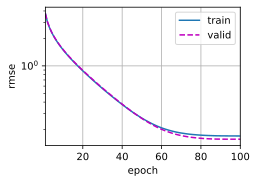

In [132]:
k  , num_epochs ,lr, weight_decay, batch_size = 5 , 100, 5, 0, 64
train_l , valid_l = k_fold(k, train_features, train_labels , num_epochs, lr, weight_decay, batch_size)

print(f'{k} 折交叉验证:平均训练log rmse {float(train_l):f} ',
      f'平均验证log rmse {float(valid_l):f}')

提交Kaggle预测

In [134]:
import numpy as np
def train_and_pred(train_features, test_features, train_labels, 
                   test_data,num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, 
                        num_epochs, lr, weight_decay, batch_size )
    d2l.plot(np.arange(1, num_epochs+1), [train_ls], xlabel='epoch',
              ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练 log mse {float(train_ls[-1]):f}')

    preds = net(test_features).detach().numpy()

    test_data ['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis = 1)
    submission.to_csv('../data/submission.csv', index=False)


训练 log mse 0.162546


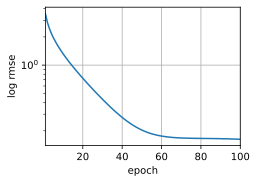

In [135]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)

折1, 训练log rmse 0.268350,  验证log rmse 0.220237
折2, 训练log rmse 0.223898,  验证log rmse 0.286629
折3, 训练log rmse 0.232086,  验证log rmse 0.248836
折4, 训练log rmse 0.264144,  验证log rmse 0.194924
折5, 训练log rmse 0.244641,  验证log rmse 0.234576
5 折交叉验证:平均训练log rmse 0.246624  平均验证log rmse  0.237040


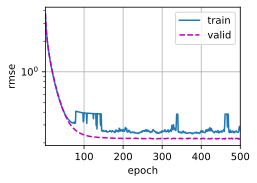

In [92]:
k  , num_epochs ,lr, weight_decay, batch_size = 5 , 500, 5, 10, 64
train_l , valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)

print(f'{k} 折交叉验证:平均训练log rmse {float(train_l):f} ',
                  f'平均验证log rmse  {float(valid_l):f}')

折1, 训练log rmse 0.276832,  验证log rmse 0.271379
折2, 训练log rmse 0.271353,  验证log rmse 0.291746
折3, 训练log rmse 0.274008,  验证log rmse 0.295161
折4, 训练log rmse 0.276105,  验证log rmse 0.240704
折5, 训练log rmse 0.270309,  验证log rmse 0.276797
5 折交叉验证:平均训练log rmse 0.273721  平均验证log rmse  0.275157


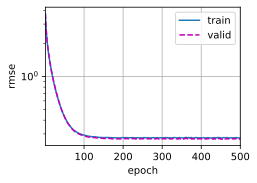

In [93]:
k  , num_epochs ,lr, weight_decay, batch_size = 5 , 500, 5, 15, 64
train_l , valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)

print(f'{k} 折交叉验证:平均训练log rmse {float(train_l):f} ',
                  f'平均验证log rmse  {float(valid_l):f}')

折1, 训练log rmse 0.276754,  验证log rmse 0.271630
折2, 训练log rmse 0.271384,  验证log rmse 0.292189
折3, 训练log rmse 0.271029,  验证log rmse 0.292009
折4, 训练log rmse 0.276211,  验证log rmse 0.240947
折5, 训练log rmse 0.272547,  验证log rmse 0.278845
5 折交叉验证:平均训练log rmse 0.273585  平均验证log rmse  0.275124


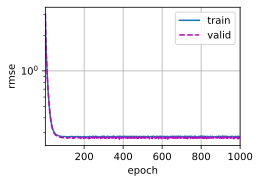

In [96]:
k  , num_epochs ,lr, weight_decay, batch_size = 5 , 1000, 10, 15, 64
train_l , valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)

print(f'{k} 折交叉验证:平均训练log rmse {float(train_l):f} ',
                  f'平均验证log rmse  {float(valid_l):f}')

In [115]:
dp = 0.2
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 100),
                        nn.ReLU(),
                        nn.Dropout(dp),
                        nn.Linear(100, 40),
                        nn.ReLU(),
                        nn.Dropout(dp),
                        nn.Linear(40, 1)

                        )
    return net

折1, 训练log rmse 1.520672,  验证log rmse 1.525686


KeyboardInterrupt: 

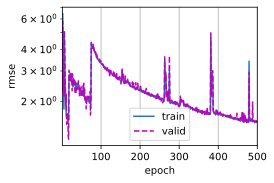

In [117]:
k  , num_epochs ,lr, weight_decay, batch_size = 5 , 500, 5, 5, 64
train_l , valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)

print(f'{k} 折交叉验证:平均训练log rmse {float(train_l):f} ',
                  f'平均验证log rmse  {float(valid_l):f}')